## This compares to DoubleBracketIteration whenever possible

In [1]:
import inspect
import sys
sys.path.append("../../tests")
from test_models_dbi import *
def print_function_source_code( func ):
    out = inspect.getsourcelines(func)  
    from functools import reduce
    print(reduce(str.__add__, out[0]))

# Check the GC bound is valid



In [2]:
print_function_source_code(test_double_bracket_iteration_eval_dbr_unitary)

@pytest.mark.parametrize("nqubits", [3])
def test_double_bracket_iteration_eval_dbr_unitary(backend, nqubits):
    r"""The bound is $$||e^{-[D,H]}-GC||\le s^{3/2}(||[H,[D,H]||+||[D,[D,H]]||$$"""
    h0 = random_hermitian(2**nqubits, backend=backend)
    d = backend.cast(np.diag(np.diag(backend.to_numpy(h0))))
    dbi = DoubleBracketIteration(
        Hamiltonian(nqubits, h0, backend=backend),
        mode=DoubleBracketGeneratorType.group_commutator,
    )

    for s in np.linspace(0.001, 0.01, NSTEPS):
        u = dbi.eval_dbr_unitary(s,d=d, mode=DoubleBracketGeneratorType.single_commutator)
        v = dbi.eval_dbr_unitary(s,d=d, mode=DoubleBracketGeneratorType.group_commutator)

        assert np.linalg.norm(u - v) < 10 * s**1.49 * (
            np.linalg.norm(h0) + np.linalg.norm(d)
        ) * np.linalg.norm(h0) * np.linalg.norm(d)



In [2]:
import qibo
backend = qibo.backends.construct_backend("numpy")
qibo.set_backend("numpy")
nqubits = 3

[Qibo 0.2.7|INFO|2024-04-05 13:00:00]: Using numpy backend on /CPU:0


In [11]:
test_double_bracket_iteration_eval_dbr_unitary(backend, nqubits)

# Check the convergence of the Trotter-Suzuki Hamiltonian simulation oracle


In [12]:
print_function_source_code(test_dbi_evolution_oracle)

@pytest.mark.parametrize("nqubits", [3])
def test_dbi_evolution_oracle(backend,nqubits,t_step, eps):    
    from qibo.hamiltonians import SymbolicHamiltonian
    from qibo import symbols
    from numpy.linalg import norm
    print(backend)
    h_input = SymbolicHamiltonian( symbols.X(0) + symbols.Z(0) * symbols.X(1) + symbols.Y(2) 
                              + symbols.Y(1) * symbols.Y(2)+ symbols.Z(0), nqubits = 3, backend = backend )

    evolution_oracle = EvolutionOracle(h_input, "ZX",
                        mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation)
    
    evolution_oracle.eps_trottersuzuki = eps
    
    U_hamiltonian_simulation = evolution_oracle.circuit(t_step).unitary()
    V_target = h_input.exp(t_step)
    
    assert norm(U_hamiltonian_simulation-V_target) < eps



In [15]:
test_dbi_evolution_oracle(backend,nqubits,1 ,1e-2)

[Qibo 0.2.7|WARNING|2024-04-05 12:26:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


numpy


# Check the numerical mode of evolution oracles

This is testing the following:

`dbi` runs $V = e^{-sW}$ and rotates $H_1 = V^\dagger H_0 V$.

`gci` runs $Q = GC$ and rotates $J_1 = Q^\dagger H_0 Q$.

`dbi2` runs $R = GC$ and rotates $K_1 = R^\dagger H_0 R$.

We assert that gci and dbi2 should be within machine precision for the correct sorting.
$$||J_1-K_1||\le2 ||H_0||\,||R-Q||\le \epsilon$$

We assert that gci and dbi should be within the approximation bound of the GC
$$||J_1-H_1||\le2 ||H_0||\,||R-V||\le C ||H_0|| s^{3/2}$$


In [ ]:
def test_dbr_in_dbi_vs_gci_classes_numerical(t_step, eps):

In [10]:
t_step =0.1
eps = 1e-2

In [11]:
from numpy.linalg import norm
h_x = SymbolicHamiltonian( symbols.X(0) + symbols.Z(0) * symbols.X(1) + symbols.Y(2) 
                          + symbols.Y(1) * symbols.Y(2), nqubits = 3 )
d_0 = SymbolicHamiltonian(symbols.Z(0), nqubits = 3 )
h_input = h_x + d_0 

dbi = DoubleBracketIteration(deepcopy(h_input.dense))
dbi.mode = DoubleBracketGeneratorType.single_commutator


dbi2 = DoubleBracketIteration(deepcopy(h_input.dense))
dbi2.mode = DoubleBracketGeneratorType.group_commutator

V_dbi = dbi.eval_dbr_unitary(t_step, d=d_0.dense.matrix)
R_dbi = dbi2.eval_dbr_unitary(t_step, d=d_0.dense.matrix)


evolution_oracle = EvolutionOracle(h_input, "ZX",
                    mode_evolution_oracle = EvolutionOracleType.numerical)    

evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
           mode_evolution_oracle = EvolutionOracleType.numerical)

gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle ))
#gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator

unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step), evolution_oracle_diagonal_target )   
Q_gci = unitary_gc_from_oracles['forwards']

assert norm(Q_gci.conj().T - unitary_gc_from_oracles['backwards']) < 1e-12
h0_norm = np.linalg.norm(h_x.dense.matrix)
d0_norm = np.linalg.norm(d_0.dense.matrix)
assert norm(V_dbi - R_dbi) < 2 *t_step**1.49 * ( h0_norm + d0_norm ) * h0_norm * d0_norm

[Qibo 0.2.7|WARNING|2024-04-05 13:02:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-05 13:02:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-05 13:02:38]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


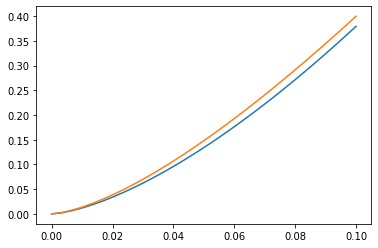

In [19]:
import matplotlib.pyplot as plt
norms  = []
for r in np.linspace(1e-5,0.1,30):
    V_dbi = dbi.eval_dbr_unitary(r, d=d_0.dense.matrix)
    R_dbi = dbi2.eval_dbr_unitary(r, d=d_0.dense.matrix)
    norms.append(norm(V_dbi.conj().T -  R_dbi))
    
plt.plot(np.linspace(1e-5,.1,30), [x**1.5*12 for x in np.linspace(1e-5,.1,30)])
plt.plot(np.linspace(1e-5,.1,30),norms)

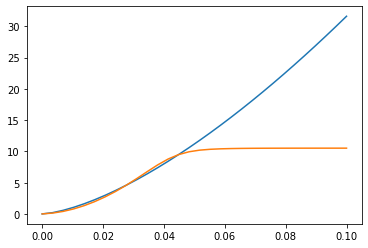

In [27]:

dbi = DoubleBracketIteration(deepcopy(h_input.dense))
dbi.mode = DoubleBracketGeneratorType.single_commutator


dbi2 = DoubleBracketIteration(deepcopy(h_input.dense))
dbi2.mode = DoubleBracketGeneratorType.group_commutator

import matplotlib.pyplot as plt
norms  = []
for r in np.linspace(1e-5,0.1,30):
    dbi(r, d=d_0.dense.matrix)
    dbi2(r, d=d_0.dense.matrix)
    norms.append(norm(dbi.h.matrix- dbi2.h.matrix))
    
plt.plot(np.linspace(1e-5,.1,30), [x**1.5*1000 for x in np.linspace(1e-5,.1,30)])
plt.plot(np.linspace(1e-5,.1,30),norms)

In [12]:
norm(Q_gci.conj().T - R_dbi )

1.0885506896087478

In [13]:
norm(Q_gci - R_dbi )

1.8837381116044358

In [5]:
assert norm(Q_gci.conj().T - R_dbi ) < 5*eps

dbi(t_step, d = d_0.dense.matrix )
h_1 = dbi.h.matrix
dbi2(t_step, d = d_0.dense.matrix )
k_1 = dbi2.h.matirix
gci(t_step, d = d_0.dense.matrix )
j_1 = gci.iterated_hamiltonian_evolution_oracle.h
print(norm(j_1-k_1))
print(norm(V_dbi-Q_dbi))
print(norm(h_1-k_1))    
print(norm(V_dbi-R_dbi))

In [6]:
test_dbr_in_dbi_vs_gci_classes_numerical(.1, 1e-5)

[Qibo 0.2.7|WARNING|2024-04-05 13:01:50]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-05 13:01:50]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-05 13:01:50]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


AssertionError: 

In [12]:
type(np.array([2]))

numpy.ndarray

# Show that double bracket iteration group commutator and dbi converge for small s BHMM

This is testing the following:

`dbi` runs $V = e^{-sW}$ and rotates $H_1 = V^\dagger H_0 V$.

`gci` runs $Q = GC$ and rotates $J_1 = Q^\dagger H_0 Q$.

`dbi2` runs $R = GC$ and rotates $K_1 = R^\dagger H_0 R$.

We assert that gci and dbi2 should be within machine precision for the correct sorting.
$$||J_1-K_1||\le2 ||H_0||\,||R-Q||\le \epsilon$$

We assert that gci and dbi should be within the approximation bound of the GC
$$||J_1-H_1||\le2 ||H_0||\,||R-V||\le C ||H_0|| s^{3/2}$$


[Qibo 0.2.7|WARNING|2024-04-06 16:29:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.
[Qibo 0.2.7|WARNING|2024-04-06 16:29:36]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


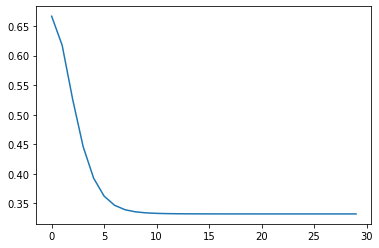

In [52]:
t_step = 0.1

h_x = SymbolicHamiltonian( symbols.X(0) + symbols.Z(0) * symbols.X(1) + symbols.Y(2) 
                          + symbols.Y(1) * symbols.Y(2), nqubits = 3 )
d_0 = SymbolicHamiltonian(symbols.Z(0), nqubits = 3 )
h_input = h_x + d_0    

dbi = DoubleBracketIteration(deepcopy(h_input.dense))
dbi.mode = DoubleBracketGeneratorType.group_commutator
dbi(t_step, d = -d_0.dense.matrix )

dbi2 = DoubleBracketIteration(deepcopy(h_input.dense))
dbi2.mode = DoubleBracketGeneratorType.single_commutator
dbi2(t_step, d = d_0.dense.matrix )

norms = []

sigma_decrease_dbi = []
sigma_decrease_gci = []
for r in range(30):
    dbi(t_step, d=-d_0.dense.matrix)
    dbi2(t_step, d=d_0.dense.matrix)
    sigma_decrease_dbi.append(dbi.off_diagonal_norm)
    
    sigma_decrease_gci.append(dbi2.off_diagonal_norm)
    norms.append(norm(dbi.h.matrix- dbi2.h.matrix))
    
    
plt.plot(norms)

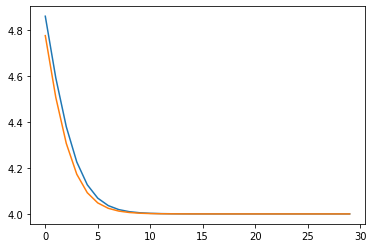

In [53]:
plt.plot(sigma_decrease_dbi)
plt.plot(sigma_decrease_gci)

In [54]:
evolution_oracle = EvolutionOracle(h_input, "ZX",
                    mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation)    
evolution_oracle.eps_trottersuzuki = eps

evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
           mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation)

gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle ))
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_other_sorting

assert norm(gci.h.matrix - dbi.h.matrix) < 1e-12   
assert norm(gci.h.matrix - dbi2.h.matrix) < 20 * norm(h_input) * t_step

dbi(t_step, d = d_0.dense.matrix )    
dbi2(t_step, d = d_0.dense.matrix )    
gci(t_step, diagonal_association=evolution_oracle_diagonal_target)  
assert norm(gci.h.matrix - dbi.h.matrix) < 1e-12   
assert norm(gci.h.matrix - dbi2.h.matrix) < (20 * norm(h_input) * t_step)**2

AttributeError: group_commutator_other_sorting

In [ ]:
from double_bracket import *

def test_dbi_vs_gci(t_step, eps):
    if t_step > 1:
        t_step = 0.1
        
    h_x = SymbolicHamiltonian( symbols.X(0) + symbols.Z(0) * symbols.X(1) + symbols.Y(2) 
                              + symbols.Y(1) * symbols.Y(2), nqubits = 3 )
    d_0 = SymbolicHamiltonian(symbols.Z(0), nqubits = 3 )
    h_input = h_x + d_0    

    dbi = DoubleBracketIteration(deepcopy(h_input.dense))
    dbi.mode = DoubleBracketGeneratorType.group_commutator
    dbi(t_step, d = d_0.dense.matrix )
    
    dbi2 = DoubleBracketIteration(deepcopy(h_input.dense))
    dbi2.mode = DoubleBracketGeneratorType.single_commutator
    dbi2(t_step, d = d_0.dense.matrix )
    
    evolution_oracle = EvolutionOracle(h_input, "ZX",
                        mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation)    
    evolution_oracle.eps_trottersuzuki = eps
    
    evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
               mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation)
    
    gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle ))
    gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_other_sorting
    
    assert norm(gci.h.matrix - dbi.h.matrix) < 1e-12   
    assert norm(gci.h.matrix - dbi2.h.matrix) < 20 * norm(h_input) * t_step
    
    dbi(t_step, d = d_0.dense.matrix )    
    dbi2(t_step, d = d_0.dense.matrix )    
    gci(t_step, diagonal_association=evolution_oracle_diagonal_target)  
    assert norm(gci.h.matrix - dbi.h.matrix) < 1e-12   
    assert norm(gci.h.matrix - dbi2.h.matrix) < (20 * norm(h_input) * t_step)**2
    
    
test_dbi_vs_gci(.1, 1e-5)

# Show that double bracket iteration group commutator and gci are numerically exact



# Show that double bracket iteration  and gci gc and gc_reduced converge for small s BHMM




In [ ]:
dbi(t_step, d = d_0.dense.matrix)


#### 2. Evolution oracle hamiltonian simulation


In [ ]:
evolution_oracle_hamiltonian_simulation = EvolutionOracle(deepcopy(h_input), "ZX",
                               mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation)


In [ ]:
evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
               mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation)



In [ ]:
t_step = 1
def check_hs_eps(eps):
    evolution_oracle_hamiltonian_simulation.eps_trottersuzuki = eps
    U_hamiltonian_simulation = evolution_oracle_hamiltonian_simulation.circuit(t_step).unitary()
    V_target = h_input.exp(t_step)
    print(eps,norm(U_hamiltonian_simulation-V_target))

In [ ]:
check_hs_eps(0.1)

In [ ]:
check_hs_eps(.001)

In [ ]:
check_hs_eps(1e-4)

In [ ]:

gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle_hamiltonian_simulation ))
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_other_sorting


In [ ]:
gci.iterated_hamiltonian_evolution_oracle.h

In [ ]:
unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step),
           diagonal_association_evolution_oracle = evolution_oracle_diagonal_target )

In [ ]:
for a in DoubleBracketRotationType:
    print(a.name)

In [ ]:
def test_gc_numerical_vs_circuit(eps):
    gci.iterated_hamiltonian_evolution_oracle.eps_trottersuzuki = eps
    evolution_oracle_diagonal_target.eps_trottersuzuki = eps
    
    gci.iterated_hamiltonian_evolution_oracle.please_be_verbose = False
    evolution_oracle_diagonal_target.please_be_verbose = False
    

    gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_reduced

    gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.numerical
    evolution_oracle_diagonal_target.mode_evolution_oracle  = EvolutionOracleType.numerical

    unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step),
           diagonal_association_evolution_oracle = evolution_oracle_diagonal_target )

    unitary_gc_existing = wrapper_gc(dbi, np.sqrt(t_step),d_0.dense.matrix)

    bckwd = unitary_gc_from_oracles['backwards']
    fwd = unitary_gc_from_oracles['forwards']

    e1 = gci.iterated_hamiltonian_evolution_oracle.circuit(np.sqrt(t_step))
    e2 = evolution_oracle_diagonal_target.circuit(np.sqrt(t_step))

    gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation
    evolution_oracle_diagonal_target.mode_evolution_oracle  = EvolutionOracleType.hamiltonian_simulation

    unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step),
           diagonal_association_evolution_oracle = evolution_oracle_diagonal_target )

    unitary_gc_existing = wrapper_gc(dbi, np.sqrt(t_step),d_0.dense.matrix)

    bckwdhs = unitary_gc_from_oracles['backwards'].unitary()
    fwdhs = unitary_gc_from_oracles['forwards'].unitary()

    e1hs = gci.iterated_hamiltonian_evolution_oracle.circuit(np.sqrt(t_step)).unitary()
    e2hs = evolution_oracle_diagonal_target.circuit(np.sqrt(t_step)).unitary()

    print("e1:", norm( e1hs-e1))
    print("e2:", norm(e2hs-e2))
    print("Testing inversion forwards:", norm(bckwd-bckwdhs))
    print("Testing inversion backwards:", norm(fwd - fwdhs))

test_gc_numerical_vs_circuit(0.1)

test_gc_numerical_vs_circuit(0.0001)

In [ ]:
def test_group_commutator_against_itself(gci, evolution_diagonal,eps = 0.0001):
    gci.iterated_hamiltonian_evolution_oracle.eps_trottersuzuki = eps
    evolution_oracle_diagonal_target.eps_trottersuzuki = eps
    for s in np.linspace(0,1,5):
        gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation
        evolution_diagonal.mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation
        gc_hs = gci.group_commutator(s,evolution_diagonal)
        gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.numerical
        evolution_diagonal.mode_evolution_oracle = EvolutionOracleType.numerical
        gc_np = gci.group_commutator(s,evolution_diagonal)
        print(norm(gc_np['forwards']-gc_hs['forwards'].unitary()))
        print(norm(gc_np['backwards']-gc_hs['backwards'].unitary()))

gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator        
test_group_commutator_against_itself(gci, evolution_oracle_diagonal_target)

gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_other_sorting        
test_group_commutator_against_itself(gci, evolution_oracle_diagonal_target)

gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_reduced      
test_group_commutator_against_itself(gci, evolution_oracle_diagonal_target)

In [ ]:
def test_gc_numerical_vs_bracket(eps = 0.3):
    gci.iterated_hamiltonian_evolution_oracle.eps_trottersuzuki = eps
    evolution_oracle_diagonal_target.eps_trottersuzuki = eps
    
    gci.iterated_hamiltonian_evolution_oracle.please_be_verbose = False
    evolution_oracle_diagonal_target.please_be_verbose = False
    

    gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator

    gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.numerical
    evolution_oracle_diagonal_target.mode_evolution_oracle  = EvolutionOracleType.numerical

    unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step),
           diagonal_association_evolution_oracle = evolution_oracle_diagonal_target )

    import scipy
    unitary_gc_existing1 = scipy.linalg.expm( t_step * (d_0.dense.matrix @ h_x.dense.matrix
                                         -h_x.dense.matrix@d_0.dense.matrix))

    bckwd = unitary_gc_from_oracles['backwards']
    fwd = unitary_gc_from_oracles['forwards']

    e1 = gci.iterated_hamiltonian_evolution_oracle.circuit(np.sqrt(t_step))
    e2 = evolution_oracle_diagonal_target.circuit(np.sqrt(t_step))

    gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation
    evolution_oracle_diagonal_target.mode_evolution_oracle  = EvolutionOracleType.hamiltonian_simulation

    unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step),
           diagonal_association_evolution_oracle = evolution_oracle_diagonal_target )

    unitary_gc_existing = wrapper_gc(dbi, np.sqrt(t_step),-d_0.dense.matrix)

    bckwdhs = unitary_gc_from_oracles['backwards'].unitary()
    fwdhs = unitary_gc_from_oracles['forwards'].unitary()

    e1hs = gci.iterated_hamiltonian_evolution_oracle.circuit(np.sqrt(t_step)).unitary()
    e2hs = evolution_oracle_diagonal_target.circuit(np.sqrt(t_step)).unitary()
    print("Test:", norm(unitary_gc_existing-unitary_gc_existing1))
    print("e1:", norm( e1hs-e1))
    print("e2:", norm(e2hs-e2))
    print("Testing inversion forwards:", norm(bckwd-bckwdhs))
    print("Testing inversion backwards:", norm(fwd - fwdhs))

test_gc_numerical_vs_bracket(0.1)

test_gc_numerical_vs_bracket(0.0001)

In [ ]:
def gc_hs_eps(eps):
    gci.iterated_hamiltonian_evolution_oracle.eps_trottersuzuki = eps
    evolution_oracle_diagonal_target.eps_trottersuzuki = eps
    
    gci.iterated_hamiltonian_evolution_oracle.please_be_verbose = True
    evolution_oracle_diagonal_target.please_be_verbose = False
    
    gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.numerical
    evolution_oracle_diagonal_target.mode_evolution_oracle  = EvolutionOracleType.numerical

    gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator
    
    unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step),
               diagonal_association_evolution_oracle = evolution_oracle_diagonal_target )
    
    unitary_gc_existing = wrapper_gc(dbi, np.sqrt(t_step),-d_0.dense.matrix)
    
    bckwd = unitary_gc_from_oracles['backwards']
    fwd = unitary_gc_from_oracles['forwards']
    
    e1 = gci.iterated_hamiltonian_evolution_oracle.circuit(np.sqrt(t_step))
    e2 = evolution_oracle_diagonal_target.circuit(np.sqrt(t_step))
    
    print("Backwards:", norm( bckwd - unitary_gc_existing))
    print("Forwards:", norm(fwd - unitary_gc_existing))
    print("Testing inversion forwards:", norm(fwd - e2.conj().T @ e1.conj().T @ e2 @e1))
    print("Testing inversion backwards:", norm(bckwd - e2.conj().T @ e1.conj().T @ e2 @e1))
    print("Testing inversion forwards:", norm(fwd - e1.conj().T @ e2.conj().T @  e1 @e2))
    print("Testing inversion backwards:", norm(bckwd - e1.conj().T @ e2.conj().T @  e1 @e2))
    print("Testing inversion forwards:", norm(fwd - e1@e2@ e1.conj().T @ e2.conj().T ))
    print("Testing inversion backwards:", norm(bckwd - e1@e2@e1.conj().T @ e2.conj().T ))
    print("Testing inversion forwards:", norm(fwd - e1.conj().T@e2@ e1 @ e2.conj().T ))
    print("Testing inversion backwards:", norm(bckwd - e1.conj().T@e2@e1 @ e2.conj().T ))
    print("Testing reversal:", norm(bckwd@fwd - unitary_gc_existing @unitary_gc_existing.T.conj() ))
    print("Testing reversal:", norm(bckwd@fwd - e1@e1.conj().T ))

In [ ]:
gc_hs_eps(0.1)

We may improve the discrepancy by setting smaller eps

In [ ]:
gc_hs_eps(0.0001)

In [ ]:
norm(unitary_gc_from_oracles['forwards'].unitary() - unitary_gc_existing)

In [ ]:
norm(unitary_gc_from_oracles['backwards'].unitary() - unitary_gc_existing)

In [ ]:
stop

#### Test more explicitly


In [ ]:
u_h = gci.iterated_hamiltonian_evolution_oracle.circuit( np.sqrt(t_step)).unitary()
u_d = evolution_oracle_diagonal_target.circuit( np.sqrt(t_step)).unitary()
u_h_reversed = gci.iterated_hamiltonian_evolution_oracle.circuit( -np.sqrt(t_step)).unitary()
u_d_reversed = evolution_oracle_diagonal_target.circuit( -np.sqrt(t_step)).unitary()
norm( u_h_reversed @ u_d_reversed @ u_h @ u_d - unitary_gc_existing)

In [ ]:
u_h = gci.iterated_hamiltonian_evolution_oracle.circuit( np.sqrt(t_step))
u_d = evolution_oracle_diagonal_target.circuit( np.sqrt(t_step))
u_h_reversed = gci.iterated_hamiltonian_evolution_oracle.circuit( -np.sqrt(t_step))
u_d_reversed = evolution_oracle_diagonal_target.circuit( -np.sqrt(t_step))
norm( (u_h_reversed + u_d_reversed + u_h + u_d).unitary() - unitary_gc_existing)

#### 3. Evolution oracle numpy


In [ ]:
evolution_oracle_numerical = EvolutionOracle(deepcopy(h_input), "ZX",
                               mode_evolution_oracle = EvolutionOracleType.numerical)

gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle_numerical ))

In [ ]:
evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
               mode_evolution_oracle=EvolutionOracleType.numerical)


In [ ]:
unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step),
           diagonal_association_evolution_oracle = evolution_oracle_diagonal_target )

Compared to the group commutator using Hamiltonian simulation there will be small deviations that arise from Trotter-Suzuki decomposition

In [ ]:
norm(unitary_gc_from_oracles['backwards'] - unitary_gc_existing)

In [ ]:
norm(unitary_gc_from_oracles['forwards'] - unitary_gc_existing)

We may check by switching the group commutator flag that the difference comes from ordering and inversions

In [ ]:
gci.mode_double_bracket_rotation = DoubleBracketRotationType.group_commutator_other_sorting

unitary_gc_from_oracles = gci.group_commutator( np.sqrt(t_step),
           diagonal_association_evolution_oracle = evolution_oracle_diagonal_target )
norm(unitary_gc_from_oracles['forwards'] - unitary_gc_existing)

#### 4. Check gci rotation

In [ ]:
evolution_oracle_hamiltonian_simulation = EvolutionOracle(deepcopy(h_input), "ZX",
                               mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation)
evolution_oracle_diagonal_target =  EvolutionOracle(d_0, "D0",
               mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation)
gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(evolution_oracle_hamiltonian_simulation ))

In [ ]:
type(gci.iterated_hamiltonian_evolution_oracle)

In [ ]:
gci(t_step, diagonal_association=evolution_oracle_diagonal_target)

In [ ]:
type(gci.iterated_hamiltonian_evolution_oracle)

In [ ]:
gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle

In [ ]:
u_frame_shifted = gci.iterated_hamiltonian_evolution_oracle.circuit(t_step).unitary()

In [ ]:
norm( dbi.h.exp(t_step) - u_frame_shifted)

In [ ]:
gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle


In [ ]:
gci(t_step, diagonal_association=evolution_oracle_diagonal_target)

In [ ]:
dbi(t_step, d = evolution_oracle_diagonal_target.h.dense.matrix)

In [ ]:
u_frame_shifted = gci.iterated_hamiltonian_evolution_oracle.circuit(t_step).unitary()


In [ ]:
norm( dbi.h.exp(t_step) - u_frame_shifted)

In [ ]:
for k in range(3):
    gci(t_step, diagonal_association=evolution_oracle_diagonal_target)
    dbi(t_step, d = evolution_oracle_diagonal_target.h.dense.matrix)
    print(norm( dbi.h.exp(t_step) - u_frame_shifted))

In [ ]:
gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation

In [ ]:
gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.numerical
gc_numpy = gci.group_commutator( np.sqrt(t_step),
                                             diagonal_association_evolution_oracle= EvolutionOracle(d_0, "D0",mode_evolution_oracle=EvolutionOracleType.numerical))

In [ ]:
## Test more fancy functionalities
input_hamiltonian_evolution_oracle_hamiltonian_simulation.please_be_verbose = False
gci = GroupCommutatorIterationWithEvolutionOracles( deepcopy(input_hamiltonian_evolution_oracle_hamiltonian_simulation ))
d_ev =  EvolutionOracle(d_0, "D0",mode_evolution_oracle=EvolutionOracleType.hamiltonian_simulation)

gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.hamiltonian_simulation
query_list = gci.group_commutator( np.sqrt(t_step),
                                             diagonal_association_evolution_oracle= d_ev )

norm(query_list['forwards'].unitary() -query_list['backwards'].unitary().conj().T)




In [ ]:
norm(query_list['forwards'] -query_list['backwards'].T.conj())

In [ ]:
#Test file entry
u = gci.iterated_hamiltonian_evolution_oracle.circuit( np.sqrt(t_step)).unitary()
u2 = gci.iterated_hamiltonian_evolution_oracle.circuit( -np.sqrt(t_step)).unitary()
norm(u-u2.T.conj())

In [ ]:
d_0.mode_evolution_oracle = EvolutionOracleType.text_strings
gci.iterated_hamiltonian_evolution_oracle.mode_evolution_oracle = EvolutionOracleType.text_strings
query_list = gci.group_commutator( np.sqrt(t_step*2),
             diagonal_association_evolution_oracle= EvolutionOracle(d_0, "D0"))


query_list['forwards']